# CSE 252A Computer Vision I Fall 2017
## Assignment 3

---
This assignment contains theoretical and programming exercises. If you plan to submit hand written answers for theoretical exercises, please be sure your writing is readable and merge those in order with the final pdf you create out of this notebook.

## Problem 1: Epipolar Geometry [3 pts]
Consider two cameras whose image planes are the z=1 plane, and whose focal points are at (-25, 0, 0) and (25, 0, 0). We‟ll call a point in the first camera (x, y), and a point in the second camera (u, v). Points in each camera are relative to the camera center. So, for example if (x, y) = (0, 0), this is really the point (-25, 0, 1) in world coordinates, while if (u, v) = (0, 0) this is the point (25, 0, 1).
<img src = "fig/fig1.png",  width="500">
a) Suppose the points (x, y) = (8, 8) is matched with disparity of 7 to the point (u, v) = (1, 8). What is the 3D location of this point?

b) Consider points that lie on the line x + z = 0, y = 0. Use the same stereo set up as before. Write an analytic expression giving the disparity of a point on this line after it projects onto the two images, as a function of its position in the right image. So your expression should only involve the variables u and d (for disparity). Your expression only needs to be valid for points on the line that are in front of the cameras, i.e. with z > 1.

## Problem 2: Epipolar Rectification [4 pts]
In stereo vision, image rectification is a common preprocessing step to simplify the problem of finding
matching points between images. The goal is to warp image views such that the epipolar lines are
horizontal scan lines of the input images. Suppose that we have captured two images $I_A$ and $I_B$ from
identical calibrated cameras separated by a rigid transformation

$_{A}^{B}\textrm{T}= \begin{bmatrix}
R & t \\ 
0^T & 1
\end{bmatrix}$

Without loss of generality assume that camera A's optical center is positioned at the origin and that its optical axis is in the direction of the z-axis.

From the lecture, a rectifying transform for each image should map the epipole to the point infinitely far away in the horizontal direction $ H_{A}e_{A} = H_{B}e_{B} = [1, 0, 0]^T$. Consider the following special cases:

a) Pure horizontal translation $t = [tx, 0, 0]^T$, R = I

b) Pure translation orthogonal to the optical axis $t = [tx, ty, 0]^T$, R = I

c) Pure translation along the optical axis $t = [0, 0, tz]^T$, R = I

d) Pure rotation $t = [0, 0, 0]^T$, R is an arbitrary rotation matrix

For each of these cases, determine whether or not epipolar rectification is possible. Include the following information for each case
* The epipoles $e_A$ and $e_B$
* The equation of the epipolar line $l_B$ in $I_B$ corresponding to the point $[x_A, y_A, 1]^T$ in $I_A$ (if one exists)
* A plausible solution to the rectifying transforms $H_A$ and $H_B$ (if one exists) that attempts to minimize distortion (is as close as possible to a 2D rigid transformation). Note that the above 4 cases are special cases; a simple solution should become apparent by looking at the epipolar lines.

One or more of the above rigid transformations may be a degenerate case where rectification is not
possible or epipolar geometry does not apply. If so, explain why.

## Problem 3: NCC [3 pts]
Show that maximizing the NCC $\sum_{i,j}\tilde{W_1} (i,j)\cdot \tilde{W_2} (i,j)$ is equivalent to minimizing the NSSD $\sum_{i,j}\left | \tilde{W_1} (i,j) - \tilde{W_2} (i,j) \right |^2$.

Hint: Express $c_{NCC}$ and $c_{NSSD}$ in terms of the vectors $\tilde{w_1} =  \tilde{W_1} (:)$
and $\tilde{w_2} =  \tilde{W_2} (:)$. Thus, $c_{NCC} = \tilde{w_1}^T\tilde{w_2}$ and $c_{NSSD} = (\tilde{w_1} - \tilde{w_2})^T(\tilde{w_1} - \tilde{w_2})$,

$\tilde{W} = \frac{W - \overline{W}}{\sqrt{\sum_{k,l}(W(k,l) - \overline{W})^2}}$ is a mean-shifted and normalized version of the window. N refers to the number of pixels in each window.

## Problem 4: Sparse Stereo Matching [18 pts]

In this problem we will play around with sparse stereo matching methods. You will work on two image pairs, a warrior figure and a figure from the Matrix movies. These files both contain two images, two camera matrices, and set sets of corresponding points (extracted by manually clicking the images). For illustration, I have run my code on a third image pair (dino1.png, dino2.png). This data is also provided for you to debug your code, but you should only report results on warrior and matrix. In other words, where I include one (or a pair) of images in the assignment below, you will provide the same thing but for BOTH matrix and warrior. Note that the matrix image pair is harder, in the sense that the matching algorithms we are implementing will not work quite as well. You should expect good results, however, on warrior.

### Corner Detection [3 pts]
The first thing we need to do is to build a corner detector. This should be done according to http://cseweb.ucsd.edu/classes/fa17/cse252A-a/lec11.pdf. Your should fill in the function <code>corner_detect</code> below, and take as <code>input corner_detect(image, nCorners, smoothSTD, windowSize)</code> where smoothSTD is the standard deviation of the smoothing kernel and windowSize is the window size for corner detector and non maximum suppression. In the lecture the corner detector was implemented using a hard threshold. Do not do that but instead return the nCorners strongest corners after non-maximum suppression. This way you can control exactly how many corners are returned. Run your code on all four images (with nCorners = 20) and show outputs as in Figure 2. You may find scipy.ndimage.filters.gaussian_filter easy to use for smoothing. In this problem try different parameters and then comment on results.
1. windowSize = 3, 5, 9, 17
2. smoothSTD = 0.5, 1, 2, 4
<img src = "fig/dinoCorner1.png", alt="dino Corner 1" width="400"/> <img src = "fig/dinoCorner2.png", alt="dino Corner 2" width="400"/>


## Comment
1. With higher smoothSTD value, we can find shaper corner. This makes sense since higher smoothSTD value will make the image too be smoother and shaper corner will pop out. 
2. With larger windowsize, corner detection could find some large corner since more pixels are included in each calculation. However, also more noise is included.

In [2]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy

In [3]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [4]:
def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for corner detector and non maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).

    """
    image = scipy.ndimage.filters.gaussian_filter(image, smoothSTD)
    [col, row] = np.shape(image)
    dy_image, dx_image = np.gradient(image)
    dyy = dy_image**2
    dxx = dx_image**2
    dxy = dx_image * dy_image
#     dx_image = np.diff(image)
#     dy_image = np.diff(image.T)
    
    colwin = np.int(np.floor(col/windowSize))
    rowwin = np.int(np.floor(row/windowSize))
    allcorner = []
    e = np.zeros((col, row))
    off = (windowSize-1)/2
    for i in range(off, col-off):
        for j in range(off, row-off):
#             C = np.array([(dx_image[i*windowSize : (i+1)*windowSize, j*windowSize : (j+1)*windowSize]**2).sum(), \
#                          (dx_image[i*windowSize : (i+1)*windowSize, j*windowSize : (j+1)*windowSize] * \
#                           dy_image[i*windowSize : (i+1)*windowSize, j*windowSize : (j+1)*windowSize]).sum(), \
#                          (dx_image[i*windowSize : (i+1)*windowSize, j*windowSize : (j+1)*windowSize] * \
#                           dy_image[i*windowSize : (i+1)*windowSize, j*windowSize : (j+1)*windowSize]).sum(), \
#                          (dy_image[i*windowSize : (i+1)*windowSize, j*windowSize : (j+1)*windowSize]**2).sum()]).reshape(2,2)
            C = np.array([dxx[i-off : i+off+1, j-off : j+off+1].sum(),
                          dxy[i-off : i+off+1, j-off : j+off+1].sum(),
                          dxy[i-off : i+off+1, j-off : j+off+1].sum(),
                          dyy[i-off : i+off+1, j-off : j+off+1].sum()]).reshape(2,2)
    
            w,v = np.linalg.eig(C)
            e[i,j] = np.min(w)
             
            # try find all corner
#             if np.min(w)>=5000:
#                 allcorner.append([i,j])

    # non maximum suppression
    # Set pixels that have an 8 neighbour with higher cornerness to zero.
    localmax = np.zeros((col, row))
    for i in range(off, col-off):
        for j in range(off, row-off):
            localmax[i,j] = e[i-off:i+off+1, j-off:j+off+1].max() == e[i,j]
    
    e_supp = localmax * e
#     print np.shape(e_supp)
#     print np.unique(e_supp)
#     print np.shape(localmax)
#     print np.unique(localmax)

    corners = np.vstack(np.where(np.in1d(e_supp, np.sort(e_supp.flatten())[-nCorners:]).reshape(col,row)))
#     corners = tmp * windowSize + (windowSize-1)/2
#     return corners.T
    return np.flip(corners.T,1)

In [730]:
# detect corners on warrior and matrix sets
# adjust your corner detection parameters here
nCorners = 20
smoothSTD = 10
windowSize = 9

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
imgs_dino = []
crns_dino = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat))
    # downsize your image in case corner_detect runs slow in test
    # imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))
    # downsize your image in case corner_detect runs slow in test
    # imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))
    
#     img_dino = imread('p4/dino/dino' + str(i) + '.png')
# #     imgs_dino.append(rgb2gray(img_dino))
# #     downsize your image in case corner_detect runs slow in test
# #     imgs_dino.append(rgb2gray(img_dino)[::2, ::2])
#     crns_dino.append(corner_detect(imgs_dino[i], nCorners, smoothSTD, windowSize))

print "finish conor detection"

finish conor detection


In [757]:
def show_corners_result(imgs, corners, name):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    ax1.scatter(corners[0][:, 0], corners[0][:, 1], s=35, edgecolors='r', facecolors='none')
    plt.title(name)

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=35, edgecolors='r', facecolors='none')
    plt.title(name)
    plt.show()

# show_corners_result(imgs_mat, crns_mat)
# show_corners_result(imgs_war, crns_war)
# show_corners_result(imgs_dino, crns_dino)

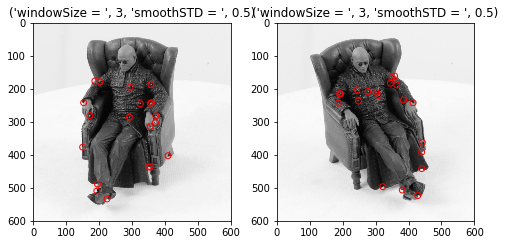

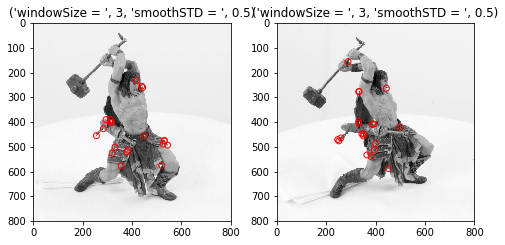

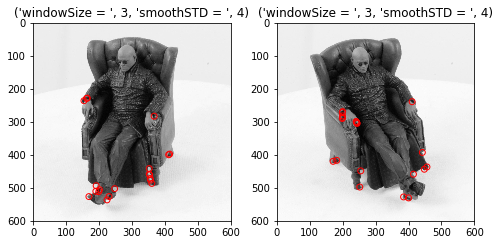

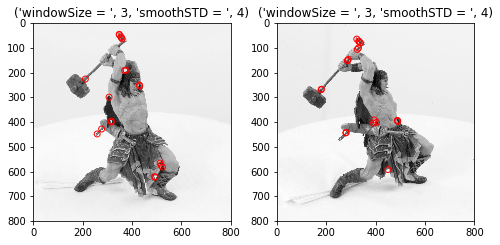

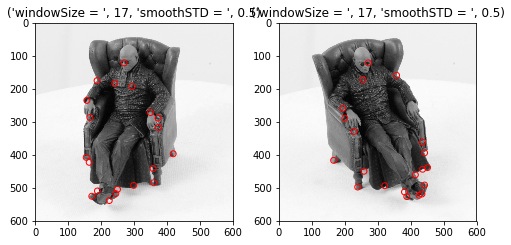

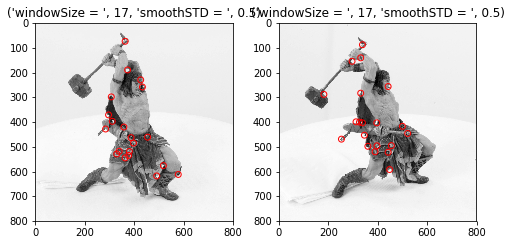

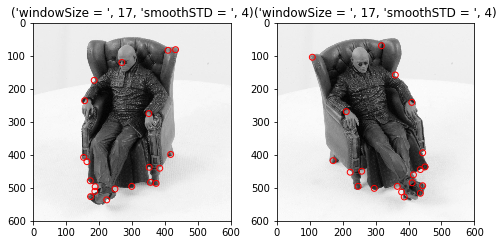

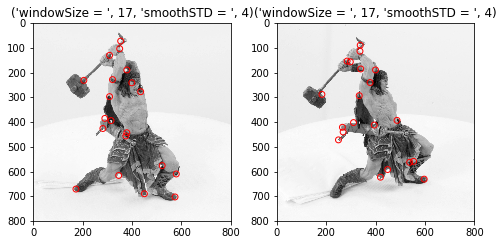

In [759]:
for windowSize in [3, 17]:
    for smoothSTD in [0.5, 4]:
        # read images and detect corners on images
        nCorners = 20
        imgs_mat = []
        crns_mat = []
        imgs_war = []
        crns_war = []
        for i in range(2):
            img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
#             imgs_mat.append(rgb2gray(img_mat))
            # downsize your image in case corner_detect runs slow in test
            imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
            crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))

            img_war = imread('p4/warrior/warrior' + str(i) + '.png')
#             imgs_war.append(rgb2gray(img_war))
            # downsize your image in case corner_detect runs slow in test
            imgs_war.append(rgb2gray(img_war)[::2, ::2])
            crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))
            
        # plot corners
        name = 'windowSize = ' windowSize 'smoothSTD = ' smoothSTD
        show_corners_result(imgs_mat, crns_mat, name)
        show_corners_result(imgs_war, crns_war, name)
#         print finish

In [756]:
print np.shape(crns_mat)

(1L, 20L, 2L)


### SSD Matching [1 pts]

Write a function ssd_match that implements the SSD matching algorithm for two input windows.

In [5]:
def ssd_match(img1, img2, c1, c2, R):
    """Compute SSD given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size

    Returns:
        SSD matching score for two input windows.

    """
    c1 = c1.astype(int)
    c2 = c2.astype(int)
    x1, y1 = c1[0], c1[1]
    x2, y2 = c2[0], c2[1]
#     patch1 = img1[y1-R:y1+R, x1-R:x1+R]
#     patch2 = img2[y2-R:y2+R, x2-R:x2+R]
#     matching_score = np.sum(np.sum(patch1**2)) + np.sum(np.sum(patch2**2)) + np.sum(np.sum(patch1 * patch2))
    
#     print y2-R
#     print '='
#     print x2-R
#     print '='
#     print y2+R+1
#     print '='
#     print x2+R+1
#     imgx, imgy = np.gradient(img1)
#     img1 = np.sqrt(imgx**2 + imgy**2)
#     imgx, imgy = np.gradient(img2)
#     img2 = np.sqrt(imgx**2 + imgy**2)
    matching_score = np.sum((img1[y1-R : y1+R+1, x1-R: x1+R+1] - img2[y2-R : y2+R+1, x2-R: x2+R+1])**2)

    return matching_score

In [537]:
# test SSD match
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])
print ssd_match(img1, img2, np.array([1, 1]), np.array([1, 1]), 1)
# should print 20
print ssd_match(img1, img2, np.array([2, 1]), np.array([2, 1]), 1)
# should print 30
print ssd_match(img1, img2, np.array([1, 1]), np.array([2, 1]), 1)
# should print 46

20
30
46
(3L, 4L)


### Naive Matching [3 pts]

Equipped with the corner detector and the SSD matching function, we are ready to start finding correspondances. One naive strategy is to try and find the best match between the two sets of corner points. Write a script that does this, namely, for each corner in image1, find the best match from the detected corners in image2 (or, if the SSD match score is too low, then return no match for that point). You will have to figure out a good threshold (SSDth) value by experimentation. Write a function naiveCorrespondanceMatching.m and call it as below. Examine your results for 10, 20, and 30 detected corners in each image. Choose a number of detected corners to the maximize the number of correct matching pairs. naive_matching will call your SSD mathching code. <img src = "fig/dinoMatch.png", alt="dino match" width="800"/>

In [6]:
def naive_matching(img1, img2, corners1, corners2, R, SSDth):
    """Compute SSD given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Corners in image 1 (nx2)
        corners2: Corners in image 2 (nx2)
        R: SSD matching radius
        SSDth: SSD matching score threshold

    Returns:
        SSD matching result a list of tuple (c1, c2), 
        c1 is the 1x2 corner location in image 1, 
        c2 is the 1x2 corner location in image 2. 

    """
    
    maxidx = []
    for i in range(np.size(corners1, 0)):
        score = -np.ones((np.size(corners2)))
        for j in range(np.size(corners2, 0)):
            tmp = ssd_match(img1, img2, corners1[i, :], corners2[j, :], R)
            score[j] = tmp
        
        
        x_min = np.where(score == min([n for n in score  if n>0]))[0]
        if x_min <= SSDth:
            match = corners2[x_min, :]
    #         if score[0, :].min() > 0:
            maxidx.append([corners1[i, :].T, match.T])
            
    return tuple(maxidx)

In [686]:
# detect corners on warrior and matrix sets
# adjust your corner detection parameters here
nCorners = 10
smoothSTD = 2
windowSize = 19

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
imgs_dino = []
crns_dino = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat))
    # downsize your image in case corner_detect runs slow in test
    imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))
    imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))
    
#     img_dino = imread('p4/dino/dino' + str(i) + '.png')
# #     imgs_dino.append(rgb2gray(img_dino))
#     imgs_dino.append(rgb2gray(img_dino)[::2, ::2])
#     crns_dino.append(corner_detect(imgs_dino[i], nCorners, smoothSTD, windowSize))

In [687]:
# match corners
R = 60
SSDth = 50
matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, SSDth)
matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, SSDth)
# matching_dino = naive_matching(imgs_dino[0]/255, imgs_dino[1]/255, crns_dino[0], crns_dino[1], R, SSDth)
# print np.shape(matching_mat)

In [7]:
# plot matching result
def show_matching_result(img1, img2, matching, name):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
#     plt.savefig('dino_matching.png')
    plt.title(name)
    plt.show()

In [747]:
# show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
# # print np.shape(imgs_dino[0])
# # print np.shape(imgs_dino[1])
# # print np.shape(img_dino)
# show_matching_result(imgs_war[0], imgs_war[1], matching_war)
# # show_matching_result(imgs_dino[0], imgs_dino[1], matching_dino)

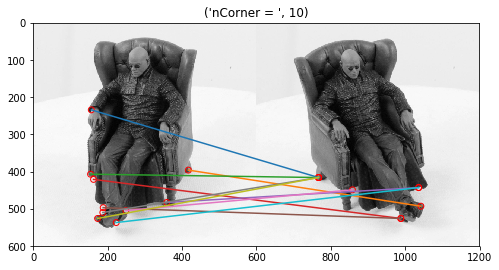

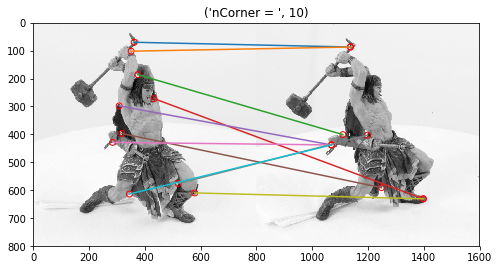

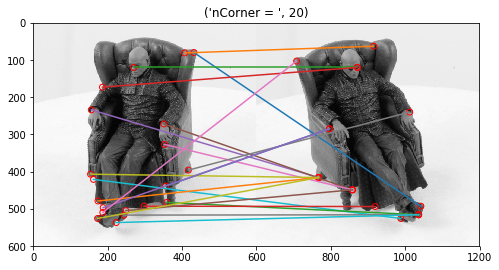

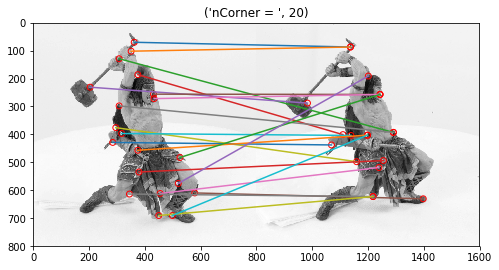

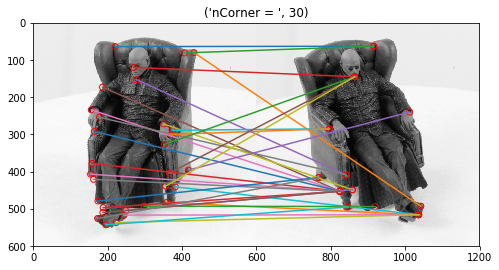

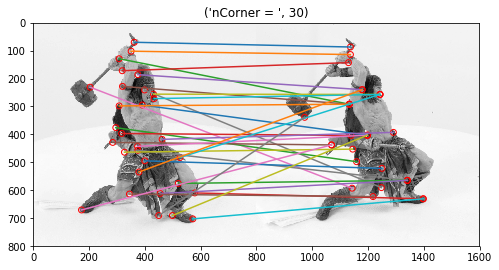

In [763]:
for nCorners in [10, 20, 30]:
    smoothSTD = 2
    windowSize = 19
    SSDth = 500
    R = 30

    # read images and detect corners on images
    imgs_mat = []
    crns_mat = []
    imgs_war = []
    crns_war = []
    imgs_dino = []
    crns_dino = []
    for i in range(2):
        img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
#         imgs_mat.append(rgb2gray(img_mat))
        # downsize your image in case corner_detect runs slow in test
        imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
        crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))

        img_war = imread('p4/warrior/warrior' + str(i) + '.png')
#         imgs_war.append(rgb2gray(img_war))
        imgs_war.append(rgb2gray(img_war)[::2, ::2])
        crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))
    
    matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, SSDth)
    matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, SSDth)
    name = 'nCorner = ', nCorners
    show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat, name)
    show_matching_result(imgs_war[0], imgs_war[1], matching_war, name)

### Epipolar Geometry [3 pts]

Using the fundamental_matrix function, and the corresponding points provided in cor1.npy and cor2.npy, calculate the fundamental matrix. 

Using this fundamental matrix, plot the epipolar lines in both image pairs across all images. For this part you may want to complete the function plot_epipolar_lines. Shown your result for matrix and warrior as the figure below. <img src = "fig/dinoEpi1.png", alt="dino epipolar" width="400"/> <img src = "fig/dinoEpi2.png", alt="dino epipolar" width="400"/>

In [8]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat

def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] 
    """
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
            
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    return F/F[2,2]


def fundamental_matrix(x1,x2):
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

In [9]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def drawline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

In [10]:
def plot_epipolar_lines(img1,img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """
    plt_cor1 = cor1[0:2, :] / cor1[2,:]
    plt_cor2 = cor2[0:2, :] / cor2[2,:]
    
    F = fundamental_matrix(cor1,cor2)
#     print F
#     print cor1

    # compute epipole
    w, v = np.linalg.eig(F)
    epipole = v[:, np.where(w<=1e-10)]
    
    epipole_plt = epipole[0:2, :] / epipole[2,:]
#     # compute second point for draw line
#     z1 = np.hstack((np.ones((np.size(epl1, 1))), (epl1[0, :] + epl1[2, :])/(-epl1[1, :])))
#     z2 = np.hstack((np.ones((np.size(epl2, 1))), (epl2[0, :] + epl2[2, :])/(-epl2[1, :])))
    
    
    epip2 = np.dot(F.T, cor1)
    epip1 = np.dot(F, cor2)
    y = 1
    # draw 
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(221)
    ax1.imshow(img1, cmap = 'gray')
    ax1.scatter(plt_cor1[0,:], plt_cor1[1,:], s=35, edgecolors='r', facecolors='none')
    for i in range(np.size(plt_cor1, 1)):
        x = np.floor(-(epip1[2, i] + epip1[1, i] * y)/epip1[0, i]).astype(int)
        drawline(np.array([x, y]), plt_cor1[:, i])
#         drawline(epipole_plt, plt_cor1[:, i])
        
    ax2 = fig.add_subplot(222)
    ax2.imshow(img2, cmap = 'gray')
    ax2.scatter(plt_cor2[0,:], plt_cor2[1,:], s=35, edgecolors='r', facecolors='none')
    for i in range(np.size(plt_cor2, 1)):
        x = np.floor(-(epip2[2, i] + epip2[1, i] * y)/epip2[0, i]).astype(int)
        drawline(np.array([x, y]), plt_cor2[:, i])
#         drawline(epipole_plt, plt_cor2[:, i])
        
    plt.show()
    

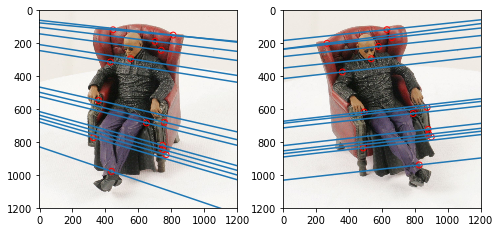

In [692]:
# replace images and corners with those of matrix and warrior
I1_mat = imread("./p4/matrix/matrix0.png")
I2_mat = imread("./p4/matrix/matrix1.png")

cor1_mat = np.load("./p4/matrix/cor1.npy")
cor2_mat = np.load("./p4/matrix/cor2.npy")
# print cor2
plot_epipolar_lines(I1_mat,I2_mat,cor1_mat,cor2_mat)

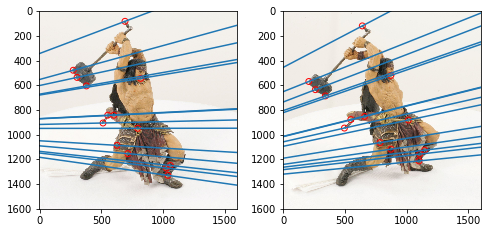

In [693]:
# replace images and corners with those of matrix and warrior
I1_war = imread("./p4/warrior/warrior0.png")
I2_war = imread("./p4/warrior/warrior1.png")

cor1_war = np.load("./p4/warrior/cor1.npy")
cor2_war = np.load("./p4/warrior/cor2.npy")
# print cor2
plot_epipolar_lines(I1_war,I2_war,cor1_war,cor2_war)

### Matching Using Epipolar Geometry [4 pts]

We will now use the epipolar geometry to build a better matching algorithm. First, detect 10 corners
in Image1. Then, for each corner, do a linesearch along the corresponding epipolar line in Image2.
Evaluate the SSD score for each point along this line and return the best match (or no match if all
scores are below the SSDth). R is the radius (size) of the SSD patch in the code below.  You do not
have to run this in both directions. Show your result as in the naive matching part.

In [17]:
print np.shape(range(0, np.size(I2, 1)))

(1900L,)


In [11]:
def correspondence_matching_epipole(img1, img2, corners1, F, R, SSDth):
    # homo to image coord.
    c1 = corners1[0:2, :] / corners1[2,:]
    # construct points
    # col = 0~ 1900
    # row = (-c-a*col)/b
    [row, col] = np.shape(img2)
#     print col
    match = []
    epip = (F.T).dot(corners1)
    for cs in range(np.size(epip, 1)):
        score = np.zeros((1, col))
        for x in range(R, col-R-1):
            y = (-(epip[2, cs] + epip[0, cs] * x)/epip[1, cs]).astype(int)
            if y >= R and y <= row-R-1:
                c2 = np.array([x, y])
                score[0, x] = ssd_match(img1, img2, c1[:, cs], c2, R)
                plt.plot(c2)
    
        if score.max() > 0:
            x_max = score.argmax()
            match.append([c1[:, cs].astype(list), [x_max, (-(epip[2, cs] + epip[0, cs] * x_max)/epip[1, cs]).astype(int)]])     
    return match

In [12]:
def display_correspondence(img1, img2, matching):
    """Plot matching result on image pair given images and correspondences

    Args:
        img1: Image 1.
        img2: Image 2.
        corrs: Corner correspondence

    """
    
    if np.shape(img1) != np.shape(img2):
        result = np.ones(img1.shape)
        result[:img2.shape[0],:img2.shape[1]] = img2
        img2 = result
#         img1 = np.vstack((img1, np.zeros((np.size(img1, 0) - np.size(img2, 0), np.size(img1, 1)))))
#         img1 = np.hstack((img1, np.zeros((np.size(img1, 0), np.size(img1, 1) - np.size(img2, 1)))))
    
#     print np.shape(img1)
#     print np.shape(img2)
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.show()

def correspondence_matching_epipole(img1, img2, corners1, F, R, SSDth):
    """Find corner correspondence along epipolar line.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Detected corners in image 1.
        F: Fundamental matrix calculated using given ground truth corner correspondences.
        R: SSD matching window radius.
        SSDth: SSD matching threshold.
    
    
    Returns:
        Matching result to be used in display_correspondence function

    """
#     w, v = np.linalg.eig(F)
#     epipole = v[:, np.where(w<=1e-10)]

    # homo to image coord.
    c1 = corners1[0:2, :] / corners1[2,:]
    # construct points
    # col = 0~ 1900
    # row = (-c-a*col)/b
    [row, col] = np.shape(img2)
#     print col
    match = []
    epip = (F.T).dot(corners1)
    # plot epipolar line see if correct of not
#     fig = plt.figure(figsize=(8, 8))
#     plt.imshow(img2, cmap = 'gray')
    asdf = np.array([[0,0]])
    for cs in range(np.size(epip, 1)):
        score = -np.ones((col))
        for x in range(R, col-R-1):
            y = (-(epip[2, cs] + epip[0, cs] * x)/epip[1, cs]).astype(int)
#             y = -(y-row)
            if y >= R and y <= row-R-1:
                c2 = np.array([x, y])
                score[x] = ssd_match(img1, img2, c1[:, cs], c2, R)
#                 print cs, [x, y]
                asdf = np.vstack((asdf, c2))
#                 print ssd_match(img1, img2, c1[:, cs], c2, R)
    
#         print score
        if min([n for n in score  if n>0]) <= SSDth:
            x_min = np.where(score == min([n for n in score  if n>0]))[0]
#             print y_max
#             print np.shape(storeC2)
            match.append([c1[:, cs].astype(list), [x_min, (-(epip[2, cs] + epip[0, cs] * x_min)/epip[1, cs]).astype(int)]])
            
            # draw epipolar line
#             print c2, [x_max, (-(epip[2, cs] + epip[0, cs] * x_max)/epip[1, cs]).astype(int)]
#             drawline(c2, np.array([x_max, (-(epip[2, cs] + epip[0, cs] * x_max)/epip[1, cs]).astype(int)]))
            
#     plot_epipolar_lines(img1,img1, corners1, corners1)    

#     plt.plot(asdf[:, 0], asdf[:, 1], '.')
    return match

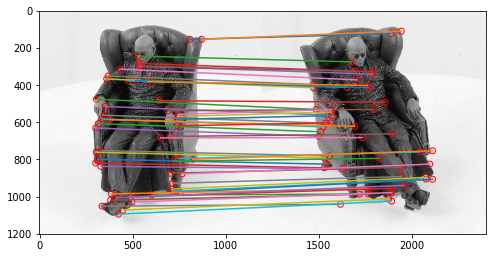

In [15]:
# replace images and corners with those of matrix and warrior
I1_mat = rgb2gray(imread("./p4/matrix/matrix0.png"))
I2_mat = rgb2gray(imread("./p4/matrix/matrix1.png"))

# force I1 and I2 to be same size
# I1 = I1[25:-25, 50: -50]
# # downsample
cor1_mat = np.load("./p4/dino/cor1.npy")
cor2_mat = np.load("./p4/dino/cor2.npy")
smoothSTD = 2
F_mat = fundamental_matrix(cor1_mat, cor2_mat)
# print np.shape(I1)
# # print np.shape(I1)

nCorners = 50
R = 60
SSDth = 6553600000
windowSize = 19
# # # detect corners using corner detector here, store in corners1
corners1_mat = corner_detect(I1_mat, nCorners, smoothSTD, windowSize)
# print type(corners1)
corners1_mat = np.hstack((corners1_mat, np.ones((np.size(corners1_mat, 0), 1)))).T
# print np.shape(corners1)
# print corners1
corrs_mat = correspondence_matching_epipole(I1_mat, I2_mat, corners1_mat, F_mat, R, SSDth)
# print corrs
display_correspondence(I1_mat, I2_mat, corrs_mat)

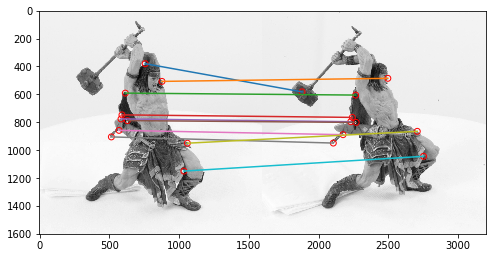

In [711]:
I1_war = rgb2gray(imread("./p4/warrior/warrior0.png"))
I2_war = rgb2gray(imread("./p4/warrior/warrior1.png"))

F_war = fundamental_matrix(cor1_war, cor2_war)
# print np.shape(I1)
# # print np.shape(I1)

nCorners = 10
R = 60
SSDth = 655360000000
# # # detect corners using corner detector here, store in corners1
corners1_war = corner_detect(I1_war, nCorners, smoothSTD, windowSize)
# print type(corners1)
corners1_war = np.hstack((corners1_war, np.ones((np.size(corners1_war, 0), 1)))).T
# print np.shape(corners1)
# print corners1
corrs_war = correspondence_matching_epipole(I1_war, I2_war, corners1_war, F_war, R, SSDth)
# print corrs
display_correspondence(I1_war, I2_war, corrs_war)

### Triangulation [4 pts]
Now that you have found correspondences between the pairs of images we can triangulate the corresponding 3D points. Since we do not enforce the ordering constraint the correspondences you have found are likely to be noisy and to contain a fair amount of outliers. Using the provided camera matrices you will triangulate a 3D point for each corresponding pair of points. Then by reprojecting the 3D points you will be able to find most of the outliers. You should implement the linear triangulation method described in lecture (For additional reference, see section 12.2 of ”Multiple View Geometry” by Hartley and Zisserman. The book is available electronically from any UCSD IP address.). P1 and P2 below are the camera matrices. Also write a function, find_outliers, that reprojects the world points to Image2, and then determines which points are outliers and inliers respectively. For this purpose, we will call a point an outlier if the distance between the true location, and the reprojected point location is more than 20 pixels.

Display your results by showing, for image 2, the original points, the inliers, and the outliers in different markers. Compare this outlierplot with your epipolar line matching result. Does the detected outliers correspond to false matches?  
<img src = "fig/dinoTri.png", alt="dino triangulation" width="400"/>. 

In [716]:
def triangulate(corsSSD, P1, P2):
    """Find corner correspondence along epipolar line.

    Args:
        corsSSD: Corner correspondence
        P1: Projection matrix 1
        P2: Projection matrix 2
    
    Returns:
        3D points from triangulation
        
    """

    x = corsSSD[0][0]
    y = corsSSD[0][1]
    x_p = corsSSD[1][0]
    y_p = corsSSD[1][1]
    pp_3 = P2[2, :]
    pp_2 = P2[1, :]
    pp_1 = P2[0, :]
    p_3 = P1[2, :]
    p_2 = P1[1, :]
    p_1 = P1[0, :]
    
    A = np.array([[x * p_3 - p_1],
                  [y * p_3 - p_2],
                  [x_p * pp_3 - pp_1],
                  [y_p * pp_3 - pp_2]]).reshape(4,4)
    U, S, V= np.linalg.svd(A)
    print S
#     print np.shape(V)
#     V = V.T
    idx = S.argmin()
    point3D = V[idx, :].reshape(4,1)
#     point3D = V[:, np.where(S<=1e-10)].reshape(4,1)
    return point3D.reshape(4)

def find_outliers(points3D, P2, outlierTH, corsSSD):
    """Find and plot outliers on image 2

    Args:
        points3D: 3D point from triangulation
        P2: Projection matrix in for image 2
        outlierTH: outlier pixel distance threshold
        corsSSD: Corner correspondence
        
    """
#     print np.shape(points3D)
#     points3D_homo = np.vstack((points3D, np.ones((1, np.size(points3D, 1)))))
    points2D_homo = P2.dot(points3D)
    points2D = points2D_homo[0:2, :]/points2D_homo[2, :]
    
#     print points3D_homo
#     print 'points2D', np.shape(points2D)
#     print 'corsSSD', np.shape(corsSSD)
    
    # creat p2 points
    p2_corn = np.zeros((np.size(corsSSD, 0), 2))
    for i in range(np.size(corsSSD, 0)):
        p2_corn[i, :] =  corsSSD[i][1]
    p2_corn = p2_corn.T
#     print 'p2_corn', p2_corn
    
    # difference in projection and original corner
    corn_diff = np.sqrt(np.sum((points2D - p2_corn)**2, axis=0))
    outlier = points2D[:, np.where(corn_diff>=outlierTH)]
#     print 'outlier', outlier
    inlier = points2D[:, np.where(corn_diff<outlierTH)]
#     print 'inlier', np.shape(inlier)
#     print 'outlier', np.shape(outlier)
#     print outlier
    return outlier, inlier, p2_corn

def plotout(imgs, corners, outlier, inlier):
    plt.imshow(imgs, cmap='gray')
    plt.scatter(corners[0, :], corners[1, :], s=35, edgecolors='r', marker = 'o', facecolors='none')
    plt.scatter(outlier[0, :], outlier[1, :], s=35, edgecolors='b', marker = 's', facecolors='none')
    plt.scatter(inlier[0, :], inlier[1, :], s=35, edgecolors='g', marker = '^', facecolors='none')
    plt.legend(['corner', 'outlier', 'inlier'])
    plt.show()



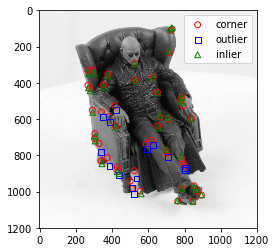

In [704]:
# # replace images and corners with those of matrix and warrior
I1 = rgb2gray(imread("./p4/matrix/matrix0.png"))
I2 = rgb2gray(imread("./p4/matrix/matrix1.png"))

cor1 = np.load("./p4/matrix/cor1.npy")
cor2 = np.load("./p4/matrix/cor2.npy")

P1 = np.load("./p4/matrix/proj1.npy")
P2 = np.load("./p4/matrix/proj2.npy")

# # print np.shape(P1)

outlierTH = 20
F = fundamental_matrix(cor1, cor2)
ncorners = 50
smoothSTD = 2
windowSize = 19
corners1 = corner_detect(I1, ncorners, smoothSTD, windowSize)
corners_homo = np.hstack((corners1, np.ones((np.size(corners1, 0), 1)))).T
corsSSD = correspondence_matching_epipole(I1, I2, corners_homo, F, R, SSDth)

# # plot corner check if corner detection correct or not
# plt.figure(figsize=(8, 8))
# plt.imshow(I1, cmap='gray')
# plt.scatter(corners1[:, 0], corners1[:, 1], s=35, edgecolors='r', facecolors='none')
# plt.show()    
# # # print 'corsSSD', np.shape(corsSSD)
# # # print np.size(corsSSD,0)

points3D = np.zeros((4, np.size(corsSSD, 0)))
for i in range(np.size(corsSSD, 0)):
    points3D[:, i] = triangulate(corsSSD[i], P1, P2)

# print 'points3D', points3D
# print 'points3D', np.shape(points3D)
# points3D = triangulate(corsSSD, P1, P2)
outlier, inlier, p2_corn = find_outliers(points3D, P2, outlierTH, corsSSD)
plotout(I2, p2_corn, outlier, inlier)


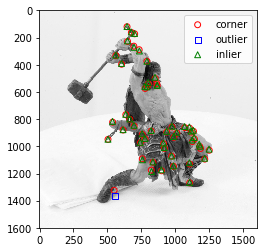

In [705]:
# # replace images and corners with those of matrix and warrior
I1 = rgb2gray(imread("./p4/warrior/warrior0.png"))
I2 = rgb2gray(imread("./p4/warrior/warrior1.png"))

cor1 = np.load("./p4/warrior/cor1.npy")
cor2 = np.load("./p4/warrior/cor2.npy")

P1 = np.load("./p4/warrior/proj1.npy")
P2 = np.load("./p4/warrior/proj2.npy")

# # print np.shape(P1)

outlierTH = 20
F = fundamental_matrix(cor1, cor2)
ncorners = 50
smoothSTD = 2
windowSize = 19
corners1 = corner_detect(I1, ncorners, smoothSTD, windowSize)
corners_homo = np.hstack((corners1, np.ones((np.size(corners1, 0), 1)))).T
corsSSD = correspondence_matching_epipole(I1, I2, corners_homo, F, R, SSDth)

# # plot corner check if corner detection correct or not
# plt.figure(figsize=(8, 8))
# plt.imshow(I1, cmap='gray')
# plt.scatter(corners1[:, 0], corners1[:, 1], s=35, edgecolors='r', facecolors='none')
# plt.show()    
# # # print 'corsSSD', np.shape(corsSSD)
# # # print np.size(corsSSD,0)

points3D = np.zeros((4, np.size(corsSSD, 0)))
for i in range(np.size(corsSSD, 0)):
    points3D[:, i] = triangulate(corsSSD[i], P1, P2)

# print 'points3D', points3D
# print 'points3D', np.shape(points3D)
# points3D = triangulate(corsSSD, P1, P2)
outlier, inlier, p2_corn = find_outliers(points3D, P2, outlierTH, corsSSD)
plotout(I2, p2_corn, outlier, inlier)


In [706]:
# corners1 = np.hstack((corners1, np.ones((np.size(corners1, 0), 1)))).T
# print np.shape(corners1)
# corsSSD = correspondence_matching_epipole(I1, I2, corners1, F, R, SSDth)
# print np.shape(corsSSD)
# print corsSSD
# print corsSSD[0]
# print corsSSD[0][1]
# # print corsSSD[1][0][1]
# # print np.vstack(corsSSD[:][1])
# # print np.size(corsSSD, 0)
# # print np.shape(P1)
# # print np.shape(points3D)

# a=np.array([[1,2,3,4],[5,6,7,8]])
# print np.sum((a**2), axis=0)

In [725]:
# # I1 = rgb2gray(imread("./p4/dino/dino0.png"))
# # I2 = rgb2gray(imread("./p4/dino/dino1.png"))

# # cor1 = np.load("./p4/dino/cor1.npy")
# # cor2 = np.load("./p4/dino/cor2.npy")

# # P1 = np.load("./p4/dino/proj1.npy")
# # P2 = np.load("./p4/dino/proj2.npy")

# # # print np.shape(P1)

# outlierTH = 20
# F = fundamental_matrix(cor1, cor2)
# ncorners = 50
# smoothSTD = 2
# windowSize = 19
# R = 30
# # corners1 = corner_detect(I1, ncorners, smoothSTD, windowSize)
# # corners_homo = np.hstack((corners1, np.ones((np.size(corners1, 0), 1)))).T
# corsSSD = correspondence_matching_epipole(I1, I2, corners_homo, F, R, SSDth)

# # # plot corner check if corner detection correct or not
# # plt.figure(figsize=(8, 8))
# # plt.imshow(I1, cmap='gray')
# # plt.scatter(corners1[:, 0], corners1[:, 1], s=35, edgecolors='r', facecolors='none')
# # plt.show()    
# # # # print 'corsSSD', np.shape(corsSSD)
# # # # print np.size(corsSSD,0)

# points3D = np.zeros((4, np.size(corsSSD, 0)))
# for i in range(np.size(corsSSD, 0)):
#     points3D[:, i] = triangulate(corsSSD[i], P1, P2)

# # print 'points3D', points3D
# # print 'points3D', np.shape(points3D)
# # points3D = triangulate(corsSSD, P1, P2)
# outlier, inlier, p2_corn = find_outliers(points3D, P2, outlierTH, corsSSD)
# plotout(I2, p2_corn, outlier, inlier)

In [726]:
# print len(outlier)